<h2> How to read and display Nexrad on AWS using Python </h2>
<h4> Valliappa Lakshmanan, The Climate Corporation, lak@climate.com </h4>

Amazon Web Services is making NEXRAD data <a href="http://aws.amazon.com/noaa-big-data/nexrad/">freely available</a> on Amazon S3 as part of the NOAA Big Data Project. In this Python notebook, I will step you through being able to read and display this data from your Python programs.  I will assume that you know Python, how to install Python modules, and can access AWS. (Follow along by downloading and running <a href="https://github.com/lakshmanok/nexradaws">this iPython notebook</a>).

<h3> What you need </h3>

You probably have ipython and matplotlib already. In addition, you may need to install the following Python modules:
<ol>
<li> <a href="https://boto3.readthedocs.org/en/latest/guide/quickstart.html">boto</a> which I installed using conda: <pre>conda install boto</pre> </li>
<li> <a href="http://arm-doe.github.io/pyart/">pyart</a> which I installed using conda: <pre>conda install -c https://conda.anaconda.org/jjhelmus pyart</pre>
</ol>

You may also need to configure your AWS credentials to access S3.

<h3> Import modules </h3>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np
import pyart.graph
import tempfile
import pyart.io
import boto

<h3> Find volume scan </h3>

Volume scans from NEXRAD are stored on S3 such that the bucket name is noaa-nexrad-level2 and the key name is something like 2014/04/03/KLSX/KLSX20140403_211350_V06.gz i.e.  YYYY/MM/DD/KRAD/KRADYYYYMMDD_HHmmSS_V0?.gz. You can use the boto library to browse and select the keys that you want. 

Here, I'll directly navigate to a NEXRAD file that I know exists.

In [2]:
# read a volume scan file on S3. I happen to know this file exists.
s3conn = boto.connect_s3()
bucket = s3conn.get_bucket('noaa-nexrad-level2')
s3key = bucket.get_key('2015/05/15/KVWX/KVWX20150515_080737_V06.gz')
print s3key

<Key: noaa-nexrad-level2,2015/05/15/KVWX/KVWX20150515_080737_V06.gz>


<h3> Download volume scan from S3 </h3>

For further processing, it is helpful to have the file locally on disk.

In [3]:
# download to a local file, and read it
localfile = tempfile.NamedTemporaryFile()
s3key.get_contents_to_filename(localfile.name)
radar = pyart.io.read_nexrad_archive(localfile.name)

<h3> Display the data </h3>

Here, I am using PyArt to display the lowest elevation scan data of all the moments.

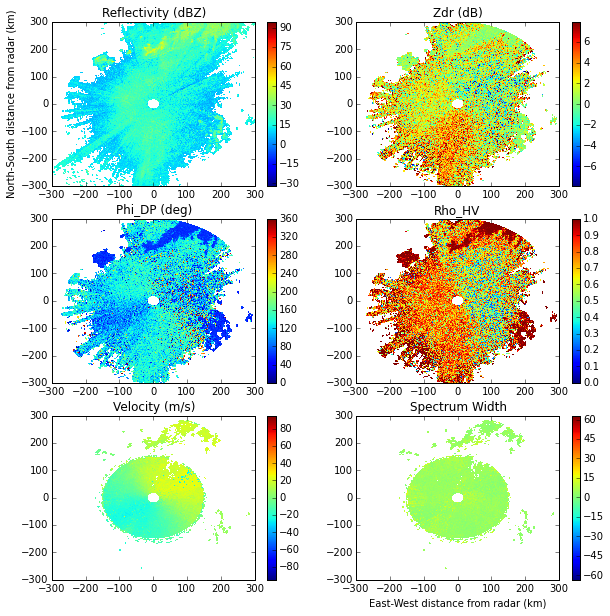

In [4]:
# display the lowest elevation scan data
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 10))

plots = [
    # variable-name in pyart, display-name that we want, sweep-number of radar (0=lowest ref, 1=lowest velocity)
    ['reflectivity', 'Reflectivity (dBZ)', 0],
    ['differential_reflectivity', 'Zdr (dB)', 0],
    ['differential_phase', 'Phi_DP (deg)', 0],
    ['cross_correlation_ratio', 'Rho_HV', 0],
    ['velocity', 'Velocity (m/s)', 1],
    ['spectrum_width', 'Spectrum Width', 1]
]

for plotno, plot in enumerate(plots, start=1):
    ax = fig.add_subplot(3, 2, plotno)
    display.plot(plot[0], plot[2], ax=ax, title=plot[1],
             colorbar_label='',
             axislabels=('East-West distance from radar (km)' if plotno == 6 else '', 
                         'North-South distance from radar (km)' if plotno == 1 else ''))
    display.set_limits((-300, 300), (-300, 300), ax=ax)

plt.show()

<h3> Processing data </h3>

Not all the reflectivity above is because of weather echoes. Most of the data are actually bioscatter (insects and birds). Let's mask the reflectivity data using the polarimetric variables to retain only approximately spherical echoes (this is not actually a good quality-control technique -- see http://journals.ametsoc.org/doi/abs/10.1175/JTECH-D-13-00073.1 -- but it is okay as a simple illustration).

In [5]:
refl_grid = radar.get_field(0, 'reflectivity')
print refl_grid[0]
rhohv_grid = radar.get_field(0, 'cross_correlation_ratio')
zdr_grid = radar.get_field(0, 'differential_reflectivity')

# apply rudimentary quality control
reflow = np.less(refl_grid, 20)
zdrhigh = np.greater(np.abs(zdr_grid), 2.3)
rhohvlow = np.less(rhohv_grid, 0.95)
notweather = np.logical_or(reflow, np.logical_or(zdrhigh, rhohvlow))
print notweather[0]

qcrefl_grid = ma.masked_where(notweather, refl_grid)
print qcrefl_grid[0]

[15.0 -3.5 -1.0 ..., -- -- --]
[True True True ..., -- -- --]
[-- -- -- ..., -- -- --]


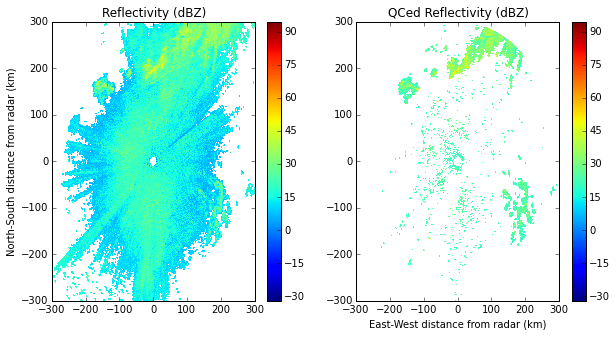

In [6]:
# let's create a new object containing only sweep=0 so we can add the QC'ed ref to it for plotting
qced = radar.extract_sweeps([0])
qced.add_field_like('reflectivity', 'reflectivityqc', qcrefl_grid)
display = pyart.graph.RadarDisplay(qced)
fig = plt.figure(figsize=(10, 5))

plots = [
    # variable-name in pyart, display-name that we want, sweep-number of radar (0=lowest ref, 1=lowest velocity)
    ['reflectivity', 'Reflectivity (dBZ)', 0],
    ['reflectivityqc', 'QCed Reflectivity (dBZ)', 0],
]

for plotno, plot in enumerate(plots, start=1):
    ax = fig.add_subplot(1, 2, plotno)
    display.plot(plot[0], plot[2], ax=ax, title=plot[1],
             colorbar_label='',
             axislabels=('East-West distance from radar (km)' if plotno == 2 else '', 
                         'North-South distance from radar (km)' if plotno == 1 else ''))
    display.set_limits((-300, 300), (-300, 300), ax=ax)

plt.show()

It is easy to see that the quality control method is quite rudimentary. The resulting field is very noisy, for one. You can see another problem in that the QCed reflectivity above is limited in range because the polarimetric radar variables do not go out to the extent of the reflectivity scan.

<h3> Acknowledgment </h3>

Thanks to NOAA and Amazon for making the NEXRAD data available.